## Black - Litterman Portfolio Optimization for the Istanbul Stock Exchange (BIST 30)

In [57]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

import cvxpy as cp

from pmdarima.arima import auto_arima

### Data Collection

In [58]:
components = pd.read_excel("endeks_agirlik_ds_genel_1.xlsx", skiprows=[0])

stocks = components[components["INDEX CODE"] == "XU030"]["EQUITY CODE"]
stocks = stocks.astype("string")
stocks = stocks.str.split(".").str[0]
stocks = stocks + ".IS"
stocks_concat = stocks.str.cat(sep = " ")

bist30 = yf.download("XU030.IS",interval = "1d", start = "2021-01-01", end = "2024-05-24")
bist30 = bist30["Adj Close"]

tlref = pd.read_csv("TRY Overnight Referance Rate Historical Data.csv")
tlref['Date'] = pd.to_datetime(tlref['Date'], format='%Y-%m-%d')

raw_data = yf.download(stocks_concat, interval = "1d", start = "2021-01-01", end = "2024-05-24")
# raw_data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  30 of 30 completed


### Data Preparation

In [59]:
stocks = stocks.str.split(".").str[0]
raw_data.columns = raw_data.columns.set_levels(stocks,level=1,)

In [60]:
DailyPrice = raw_data["Adj Close"]
# DailyPrice.fillna(method="ffill", inplace=True)
DailyPrice.ffill(inplace=True)

MonthlyPrice = DailyPrice.groupby(DailyPrice.index.strftime('%Y-%m')).tail(1)

tlref_monthly = tlref.groupby(tlref["Date"].dt.strftime("%Y-%m"))["Price"].mean()
tlref_monthly = tlref_monthly[1:] / 100
tlref_monthly = (1+tlref_monthly)**(1/12)-1

bist30_monthly = bist30.groupby(bist30.index.strftime("%Y-%m")).tail(1)
bist30_monthly = bist30_monthly.to_numpy()

bist30_returns = bist30_monthly[1:] / bist30_monthly[:-1] - 1

C:\Users\alpsr\AppData\Local\Temp/ipykernel_32548/1818437494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DailyPrice.ffill(inplace=True)


In [61]:
# Monthly Price & Returns
MonthlyPrice_All = MonthlyPrice
MonthlyPrice = MonthlyPrice[:"2024-05-01"]

t1 = MonthlyPrice.to_numpy()
t2 = t1[1:,]
t1 = t1[:-1,]

t3 = t2 / t1 - 1

Returns = pd.DataFrame(t3,columns=stocks)
Returns.index = MonthlyPrice.index[:-1]

# tlref_monthly
tlref_monthly_all = tlref_monthly
tlref_monthly = tlref_monthly[:"2024-04"]

# bist30_returns
bist30_returns_all = bist30_returns
bist30_returns = bist30_returns[:-1]

### Beta Estimation

In [62]:
# i = "AKBNK.IS"
beta = np.zeros((30,), dtype=float)
idio_return = np.zeros((30,), dtype=float)
j = 0

X = bist30_returns - tlref_monthly.to_numpy()
X = X.reshape(-1,1)

for i in Returns.columns:
   
    y = Returns[i].to_numpy() - tlref_monthly.to_numpy()
    ind = ~np.isnan(y)
    y = y[ind]
    
    linreg = LinearRegression(fit_intercept=False).fit(X[ind,],y)
    beta[j] = linreg.coef_[0]
    idio_return[j] = (linreg.predict(X[ind,]) - y).var()
    
    j = j+1

In [63]:
ExpectedMarketReturn = bist30_returns.mean()
ExpectedRiskFreeRate = tlref_monthly.to_numpy()[-1]
ExpectedStockReturns = ExpectedRiskFreeRate + beta * (ExpectedMarketReturn - ExpectedRiskFreeRate)

MarketVolatility = bist30_returns.var()

beta = beta.reshape((30,1))
CovarianceMatrix = beta @ beta.transpose()
CovarianceMatrix = MarketVolatility * CovarianceMatrix

np.fill_diagonal(CovarianceMatrix,idio_return + CovarianceMatrix.diagonal())

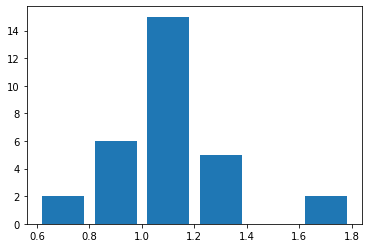

In [64]:
plt.hist(beta, rwidth=0.8, bins=np.linspace(0.60,1.80,num=7))
plt.show()

### Mean Variance Optimization

In [65]:
R = 0.06
S = np.vstack([ExpectedStockReturns, np.identity(30)])
#S = np.vstack([ExpectedStockReturns])
A = np.array([np.repeat(1,30)])
h = np.hstack([R,np.repeat(0,30)])
#h = np.hstack([R])
b = np.array([1])

x = cp.Variable(len(stocks))

prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x,CovarianceMatrix)),
                  [S @ x >= h,
                  A @ x == b])

prob.solve()

print("The optimal value is", prob.value)
print("Optimal Portfolio Weights:")
print(x.value.round(2))
# print("A dual solution corresponding to the inequality constraints is")
# print(prob.constraints[0].dual_value)

stocks = stocks.reset_index(drop = True)
# pd.DataFrame({"Stock": stocks, "Weight" : x.value}).sort_values(by = "Weight", ascending = False)

The optimal value is 0.007447096975712861
Optimal Portfolio Weights:
[ 0.06  0.03 -0.    0.03  0.05 -0.    0.07 -0.   -0.   -0.    0.03  0.
  0.03  0.04  0.03  0.06  0.02 -0.    0.04  0.    0.02  0.04  0.2  -0.
 -0.    0.01  0.13 -0.    0.01  0.09]


#### Constructing the Efficient Frontier

In [66]:
R_values = np.arange(0.045,0.065,0.001)
PortfolioRisk_MVO = np.zeros(len(R_values))
j = 0

for i in R_values:

    S = np.vstack([ExpectedStockReturns, np.identity(30)])
    #S = np.vstack([ExpectedStockReturns])
    A = np.array([np.repeat(1,30)])
    h = np.hstack([i,np.repeat(0,30)])
    #h = np.hstack([R])
    b = np.array([1])
    x = cp.Variable(len(stocks))
    

    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x,CovarianceMatrix)),
                    [S @ x >= h,
                    A @ x == b])

    prob.solve()

    PortfolioRisk_MVO[j] = prob.value

    j = j + 1


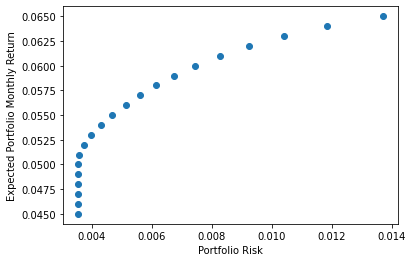

In [67]:
plt.scatter(PortfolioRisk_MVO, R_values)
plt.xlabel("Portfolio Risk")
plt.ylabel("Expected Portfolio Monthly Return")
plt.show()

In [68]:
def Markowitz(target_return, mean, covariance, swap_pos_limit, no_stocks):

    """
    Function to solve the Markovitz Portfolio Optimization problem. 
    Returns the optimal portfolio weights and the portfolio risk.
    """
    
    S = np.vstack([mean, np.identity(30)])
    A = np.array([np.repeat(1,30)])
    h = np.hstack([target_return,np.repeat(swap_pos_limit,30)])
    #h = np.hstack([R])
    b = np.array([1])

    x = cp.Variable(no_stocks)

    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x,covariance)),
                    [S @ x >= h,
                    A @ x == b])

    prob.solve()

    return x.value, prob.value

### Using Time Series Analysis to Generate Views on the Stock Returns
#### Example Case with AKBNK

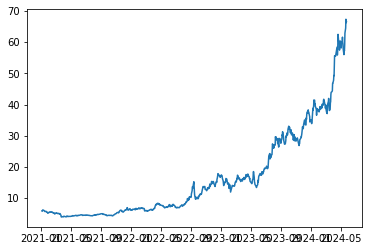

In [69]:
plt.plot(DailyPrice.index,DailyPrice["AKBNK"])
plt.show()

##### Seasonal Decomposition + ARIMA on the Residuals

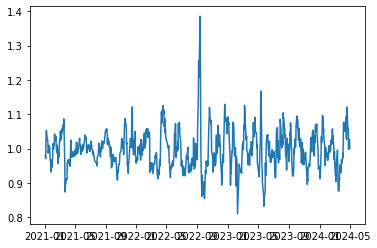

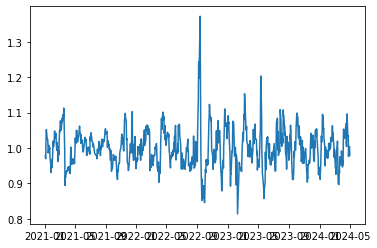

In [70]:
from statsmodels.tsa.seasonal import STL
import datetime as dt

eg = "AKBNK"

series = DailyPrice[eg]
series = series[:"2024-04-30"]
series = series[~series.isna()]

STL_decomp = STL(series,period=30).fit()

plt.plot(series.index,series.values/STL_decomp.trend)
plt.show()

detrended = series / STL_decomp.trend
decomposed = detrended / detrended.groupby([detrended.index.month]).transform('mean')

plt.plot(series.index,decomposed)
plt.show()

In [71]:
model = auto_arima(series.values, seasonal=False, trace=True)

print(model.predict(n_periods=30))
model.predict(n_periods=30)[-1]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.34 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2188.068, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1938.696, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2186.069, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1848.280, Time=0.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1782.563, Time=0.13 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1761.689, Time=0.20 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=1738.435, Time=0.28 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=1736.436, Time=0.18 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1759.689, Time=0.10 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.98 s

54.56441566548896

##### Seasonal Decomposition + ARIMA on the Residuals (version 2)

(0.01, True)

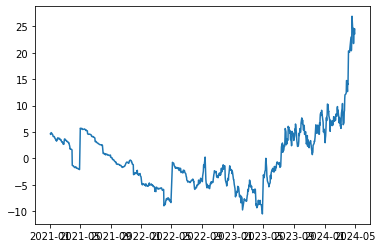

In [72]:
from sklearn.linear_model import LinearRegression

X = np.arange(0,len(series)).reshape((-1,1))

trend_model = LinearRegression(fit_intercept=False)
trend_model.fit(X=np.arange(0,len(series)).reshape((-1,1)), y=series.values)
trend = trend_model.predict(np.arange(0,len(series)).reshape((-1,1)))

detrended = series - trend
seasonal = detrended.groupby([detrended.index.month]).transform('mean')

residual = detrended - seasonal
plt.plot(residual)

from pmdarima.arima import KPSSTest

test = KPSSTest(alpha=0.1)
test.should_diff(x = residual.values)

##### Fourier Transformation
This section is still a work in progress. It will be improved in the future.

C:\Users\alpsr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


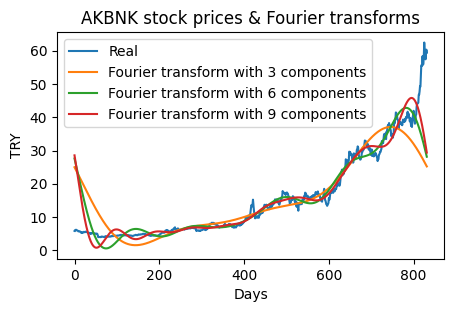

In [73]:
import pylab as pl

fr = np.fft.fft(series.to_numpy())

fourier = pd.DataFrame({'fft':fr})


fourier['absolute'] = fourier['fft'].apply(lambda x: np.abs(x))
fourier['angle'] = fourier['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(5, 3), dpi=100)
plt.plot(series.values,  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fr); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('TRY')
plt.title('AKBNK stock prices & Fourier transforms')
plt.legend()
plt.show()

[ 0.0470738  -4.15958297]


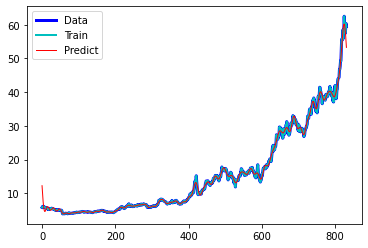

In [74]:
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 50
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    print(p)
    x_notrend = x - (p[0] * t)
    x_freqdom = np.fft.fft(x_notrend)
    f = np.fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key=lambda i: np.absolute(f[i]))

    #indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    #indexes.reverse()
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t
    
hist = series.values
train = series[:"2024-04-30"].values

n_predict = len(hist) - len(train)
extrapolation = fourierExtrapolation(train, n_predict)
pl.plot(np.arange(0, hist.size), hist, 'b', label = 'Data', linewidth = 3)
pl.plot(np.arange(0, train.size), train, 'c', label = 'Train', linewidth = 2)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'Predict', linewidth = 1)

pl.legend()
pl.show()

### Generate Predictions

In [75]:
def GenerateForecastPredictions(stock_names,data,end_date):
    
    ArimaPreds = {}
    
    for i in stock_names:
        
        series = DailyPrice[i]
        series = series[:end_date]
        series = series[~series.isna()]

        ## ARIMA START ##

        model = auto_arima(series.values, seasonal=False, trace=False)

        # print(model.summary())
        # model.get_params()["order"]
        arima_prediction = model.predict(n_periods=30)[-1]
        ArimaPreds[i] = arima_prediction

        # print(i,": ", arima_prediction)

        ## ARIMA END ##
    
    return ArimaPreds

In [76]:
Predictions = GenerateForecastPredictions(stocks,DailyPrice,"2024-04-30")

### Extracting Absolute Views from Predictions

In [77]:
Views = pd.DataFrame(Predictions.items(), columns = ["Stock", "ArimaPredPrice"])
Views["CurrentPrice"] = MonthlyPrice.loc["2024-04-30"].values
Views["ExpectedReturn"] = ExpectedStockReturns
Views["ImpliedReturn"] = Views["ArimaPredPrice"] / Views["CurrentPrice"] - 1
Views["Diff"] = (Views["ExpectedReturn"] - Views["ImpliedReturn"])*100

#print(Views.loc[abs(Views["ImpliedReturn"] - Views["ExpectedReturn"]) > 0.05,"Stock"].shape) # number of significant views
Views.loc[abs(Views["ImpliedReturn"] - Views["ExpectedReturn"]) < 0.05,"ImpliedReturn"] = 0
#print(Views.loc[Views["ImpliedReturn"] != 0,"Stock"].shape) # number of views

In [78]:
# Forming P matrix
P = np.diag(Views["ImpliedReturn"].to_numpy())
P[P > 0] = 1
P = P[~(np.all(P == 0, axis = 1))]
#print(P.shape)

# Forming q
q = Views.loc[Views["ImpliedReturn"] != 0,"ImpliedReturn"].to_numpy()
#print(q.shape)

# Forming sigma
sigma = np.diag(np.repeat(0.01, q.shape[0]))
#print(q.shape)

tau = 0.1

### Black - Littermann Portolio Optimization

In [79]:
temp_1 = np.linalg.inv(tau * CovarianceMatrix)
adj_mean = (np.linalg.inv(temp_1 + P.transpose() @ np.linalg.inv(sigma) @ P)) @ (temp_1 @ ExpectedStockReturns + P.transpose() @ np.linalg.inv(sigma) @ q)

# print((adj_mean.max()-adj_mean.min())/2+adj_mean.min())
# print(adj_mean.min())
# print(adj_mean.max())
# print((ExpectedStockReturns.max()-ExpectedStockReturns.min())/2+ExpectedStockReturns.min())
# print(ExpectedStockReturns.min())
# print(ExpectedStockReturns.max())

In [80]:
R = 0.18
S = np.vstack([adj_mean, np.identity(30)])
#S = np.vstack([ExpectedStockReturns])
A = np.array([np.repeat(1,30)])
h = np.hstack([R,np.repeat(0,30)])
#h = np.hstack([R])
b = np.array([1])

x_bl = cp.Variable(len(stocks))

prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(x_bl,CovarianceMatrix)),
                  [S @ x_bl >= h,
                  A @ x_bl == b])

prob.solve()

print("The portfolio risk is", prob.value)
print("Optimal Portfolio Weights:")
print(x_bl.value.round(2))
# print("A dual solution corresponding to the inequality constraints is")
# print(prob.constraints[0].dual_value)

The portfolio risk is 0.024521556753921685
Optimal Portfolio Weights:
[-0.   -0.   -0.   -0.    0.77 -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.
 -0.   -0.    0.23 -0.   -0.   -0.  ]


In [81]:
x_mvo_normal, var_mvo_normal = Markowitz(0.06, ExpectedStockReturns, CovarianceMatrix, 0, 30)
x_bl_normal, var_bl_normal = Markowitz(0.14, adj_mean, CovarianceMatrix, 0, len(stocks))

In [82]:
Results = pd.DataFrame(stocks.to_numpy(), columns=["Stock"])
Results["Weight_BL"] = x_bl_normal.round(3)
Results["Weight_MVO"] = x_mvo_normal.round(3)
Results["LastPrice"] = DailyPrice.iloc[[-1],:].to_numpy().reshape((30,))
# np.array(Results["LastPrice"] * Results["Weight_AvgRisk"]).sum()
Results["StartPrice"] = DailyPrice.loc["2024-04-30"].to_numpy()
Results["ActualReturn"] = Results["LastPrice"] / Results["StartPrice"] - 1
Results["ExpectedReturn"] = ExpectedStockReturns

print("Actual Returns between May 1, 2024 - May 24, 2024: \n")
print("Black-Litterman:", round(np.array(Results["ActualReturn"] * Results["Weight_BL"]).sum()*100,2))
print("Mean-Variance Optimization:", round(np.array(Results["ActualReturn"] * Results["Weight_MVO"]).sum()*100,2))
print("BIST 30:", round((bist30.iloc[-1] / bist30["2024-04-30"] - 1)*100,2))

Actual Returns between May 1, 2024 - May 24, 2024: 

Black-Litterman: 14.76
Mean-Variance Optimization: 6.34
BIST 30: 8.3


In [83]:
print("Recommended Optimal Portfolio")
print(Results[["Stock", "Weight_BL", "Weight_MVO","ExpectedReturn", "ActualReturn"]].sort_values(by=["Weight_BL"],ascending=False).round(2))

Recommended Optimal Portfolio
    Stock  Weight_BL  Weight_MVO  ExpectedReturn  ActualReturn
14  KCHOL       0.32        0.04            0.06          0.13
22  SAHOL       0.17        0.20            0.06          0.16
10  GARAN       0.16        0.03            0.06          0.21
5   BIMAS       0.12       -0.00            0.05          0.25
25  TCELL       0.11        0.01            0.06          0.15
28  TUPRS       0.10        0.01            0.06         -0.02
4   ASTOR       0.01        0.05            0.07          0.16
26  THYAO       0.01        0.14            0.06         -0.03
18   ODAS       0.00        0.04            0.06         -0.03
6   EKGYO       0.00        0.07            0.06         -0.07
12  HEKTS       0.00        0.02            0.06          0.03
0   AKBNK      -0.00        0.06            0.06          0.12
20  PETKM      -0.00        0.02            0.06          0.03
21  PGSUS      -0.00        0.04            0.06          0.02
24   SISE      -0.00     

In [85]:
x_bl_high, var_bl_high = Markowitz(0.18, adj_mean, CovarianceMatrix, 0, len(stocks))
x_bl_low, var_bl_low = Markowitz(0.1, adj_mean, CovarianceMatrix, 0, len(stocks))
x_mvo_high, var_mvo_high = Markowitz(0.065, ExpectedStockReturns, CovarianceMatrix, 0, len(stocks))
x_mvo_low, var_mvo_low = Markowitz(0.05, ExpectedStockReturns, CovarianceMatrix, 0, len(stocks))

Results["Weight_BL_Low"] = x_bl_low.round(3)
Results["Weight_BL_High"] = x_bl_high.round(3)
Results["Weight_MVO_Low"] = x_mvo_low.round(3)
Results["Weight_MVO_High"] = x_mvo_high.round(3)

In [86]:
print("Actual Returns between May 1, 2024 - May 24, 2024\n")
print("Black-Litterman Normal Risk:", round(np.array(Results["ActualReturn"] * Results["Weight_BL"]).sum()*100,2))
print("Black-Litterman Low Risk:", round(np.array(Results["ActualReturn"] * Results["Weight_BL_Low"]).sum()*100,2))
print("Black-Litterman High Risk:", round(np.array(Results["ActualReturn"] * Results["Weight_BL_High"]).sum()*100,2))
print("Mean-Variance Optimization Normal Risk:", round(np.array(Results["ActualReturn"] * Results["Weight_MVO"]).sum()*100,2))
print("Mean-Variance Optimization Low Risk:", round(np.array(Results["ActualReturn"] * Results["Weight_MVO_Low"]).sum()*100,2))
print("Mean-Variance Optimization High Risk:", round(np.array(Results["ActualReturn"] * Results["Weight_MVO_High"]).sum()*100,2))
print("BIST 30:", round((bist30.iloc[-1] / bist30["2024-04-30"] - 1)*100,2))
print("Equal Weight Portfolio:", round(sum(Results["ActualReturn"]*(1/30))*100,2))
print("------------")

print("Expected Returns of the Constructed Portfolios\n")
print("Black-Litterman Normal Risk:", round(np.array(Results["ExpectedReturn"] * Results["Weight_BL"]).sum()*100,2))
print("Black-Litterman Low Risk:", round(np.array(Results["ExpectedReturn"] * Results["Weight_BL_Low"]).sum()*100,2))
print("Black-Litterman High Risk:", round(np.array(Results["ExpectedReturn"] * Results["Weight_BL_High"]).sum()*100,2))
print("Mean-Variance Optimization Normal Risk:", round(np.array(Results["ExpectedReturn"] * Results["Weight_MVO"]).sum()*100,2))
print("Mean-Variance Optimization Low Risk:", round(np.array(Results["ExpectedReturn"] * Results["Weight_MVO_Low"]).sum()*100,2))
print("Mean-Variance Optimization High Risk:", round(np.array(Results["ExpectedReturn"] * Results["Weight_MVO_High"]).sum()*100,2))
#print("BIST 30:", round((bist30.iloc[-1] / bist30["2024-04-30"] - 1)*100,2))
print("Equal Weight Portfolio :", round(sum(Results["ExpectedReturn"]*(1/30))*100,2))

Actual Returns between May 1, 2024 - May 24, 2024

Black-Litterman Normal Risk: 14.76
Black-Litterman Low Risk: 15.3
Black-Litterman High Risk: 11.86
Mean-Variance Optimization Normal Risk: 6.34
Mean-Variance Optimization Low Risk: 15.3
Mean-Variance Optimization High Risk: 0.73
BIST 30: 8.3
Equal Weight Portfolio: 7.71
------------
Expected Returns of the Constructed Portfolios

Black-Litterman Normal Risk: 5.63
Black-Litterman Low Risk: 5.05
Black-Litterman High Risk: 6.64
Mean-Variance Optimization Normal Risk: 6.01
Mean-Variance Optimization Low Risk: 5.05
Mean-Variance Optimization High Risk: 6.49
Equal Weight Portfolio : 5.73
